In [23]:
# https://allendowney.github.io/SurvivalAnalysisPython/02_kaplan_meier.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [24]:
df = pd.read_csv('merged_df.csv')
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [25]:
df['date'] = pd.to_datetime(df['unixReviewTime'], unit='s')

In [26]:
df = df[['asin', 'reviewerID', 'date', 'overall']].sort_values(by='date')
df['prev_review_delta'] = df.groupby('asin')['date'].diff().dt.days
df.dropna(subset=['prev_review_delta'], inplace=True)

In [27]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    obs.sort_values(by='date', inplace=True)
    obs = obs.reset_index(drop=True)
    cmap = matplotlib.cm.get_cmap('Set1')
    for i, asin in enumerate(obs.asin.unique()):
        start = 0
        for j, (y, row) in enumerate(obs[obs.asin == asin].iterrows()):
    #         start = row['start']
    #         end = row['end']
    #         status = row['status']

    #         if status == 0:
    #             # ongoing
    #             plt.hlines(y, start, end, color='C0')
    #         else:
                # complete
            delay = row['prev_review_delta']
            color = cmap(i)
            plt.hlines(y, start, start+delay, color=color)
            plt.plot(start+delay, y, marker='o', color=color)
            start += delay
            
    plt.xlabel('Time (weeks)')
    plt.ylabel('Dog index')
    plt.gca().invert_yaxis()

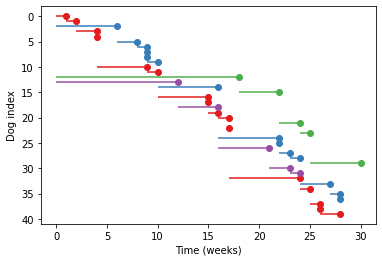

In [28]:
asins = ['B000KJVIOI', 'B000LKV7LU', 'B000G8399A', 'B000KA9I6W']
df[df.asin.isin(asins)][-50:]
plot_lifelines(df[df.asin.isin(asins)][-40:])

In [29]:
# How many purchases are made per product at time t
events = df.groupby(['asin', 'prev_review_delta'])['date'].count().rename('event_count').rename('events')
events

asin        prev_review_delta
4639725043  1.0                  1
            2.0                  1
            5.0                  1
            8.0                  1
            9.0                  1
                                ..
B000PGHLNS  60.0                 1
            63.0                 1
            75.0                 1
            100.0                1
            2376.0               1
Name: events, Length: 64122, dtype: int64

In [30]:
# How many purchase executions are "avialable" at time just before t
num_subjects = (events.groupby('asin').cumcount(ascending=False)+1).rename('num_subjects')
num_subjects

asin        prev_review_delta
4639725043  1.0                  25
            2.0                  24
            5.0                  23
            8.0                  22
            9.0                  21
                                 ..
B000PGHLNS  60.0                  5
            63.0                  4
            75.0                  3
            100.0                 2
            2376.0                1
Name: num_subjects, Length: 64122, dtype: int64

In [37]:
# Hazard rate per time t
hazard = (events / num_subjects).rename('hazard')
hazard

asin        prev_review_delta
4639725043  1.0                  0.040000
            2.0                  0.041667
            5.0                  0.043478
            8.0                  0.045455
            9.0                  0.047619
                                   ...   
B000PGHLNS  60.0                 0.200000
            63.0                 0.250000
            75.0                 0.333333
            100.0                0.500000
            2376.0               1.000000
Name: hazard, Length: 64122, dtype: float64

In [38]:
# Survival rate per time t
survival = (1 - hazard.groupby('asin').cumprod()).rename('survival')
survival

asin        prev_review_delta
4639725043  1.0                  0.960000
            2.0                  0.998333
            5.0                  0.999928
            8.0                  0.999997
            9.0                  1.000000
                                   ...   
B000PGHLNS  60.0                 1.000000
            63.0                 1.000000
            75.0                 1.000000
            100.0                1.000000
            2376.0               1.000000
Name: survival, Length: 64122, dtype: float64

In [39]:
# cdf per time t
cdf = (1 - survival).round(5).rename('cdf')
cdf

asin        prev_review_delta
4639725043  1.0                  0.04000
            2.0                  0.00167
            5.0                  0.00007
            8.0                  0.00000
            9.0                  0.00000
                                  ...   
B000PGHLNS  60.0                 0.00000
            63.0                 0.00000
            75.0                 0.00000
            100.0                0.00000
            2376.0               0.00000
Name: cdf, Length: 64122, dtype: float64

In [40]:
# Change in cdf per time t
pmf = cdf.groupby('asin').diff().fillna(0).abs().rename('pmf')
pmf

asin        prev_review_delta
4639725043  1.0                  0.00000
            2.0                  0.03833
            5.0                  0.00160
            8.0                  0.00007
            9.0                  0.00000
                                  ...   
B000PGHLNS  60.0                 0.00000
            63.0                 0.00000
            75.0                 0.00000
            100.0                0.00000
            2376.0               0.00000
Name: pmf, Length: 64122, dtype: float64

In [41]:
info = pd.concat([events, num_subjects, hazard, survival, cdf, pmf], axis=1)
info

events  num_subjects    hazard  survival  \
asin       prev_review_delta                                             
4639725043 1.0                     1            25  0.040000  0.960000   
           2.0                     1            24  0.041667  0.998333   
           5.0                     1            23  0.043478  0.999928   
           8.0                     1            22  0.045455  0.999997   
           9.0                     1            21  0.047619  1.000000   
...                              ...           ...       ...       ...   
B000PGHLNS 60.0                    1             5  0.200000  1.000000   
           63.0                    1             4  0.250000  1.000000   
           75.0                    1             3  0.333333  1.000000   
           100.0                   1             2  0.500000  1.000000   
           2376.0                  1             1  1.000000  1.000000   

                                  cdf      pmf  
asin       prev_review_delta                    
4639725043 1.0                0.04000  0.00000  
           2.0                0.00167  0.03833  
           5.0                0.00007  0.00160  
           8.0                0.00000  0.00007  
           9.0                0.00000  0.00000  
...                               ...      ...  
B000PGHLNS 60.0               0.00000  0.00000  
           63.0               0.00000  0.00000  
           75.0               0.00000  0.00000  
           100.0              0.00000  0.00000  
           2376.0             0.00000  0.00000  

[64122 rows x 6 columns]

In [44]:
info.loc['B000P6J1M2']

,events,num_subjects,hazard,survival,cdf,pmf
prev_review_delta,,,,,,
1.0,1,14,0.071429,0.928571,0.07143,0.00000
2.0,1,13,0.076923,0.994505,0.00549,0.06594
3.0,1,12,0.083333,0.999542,0.00046,0.00503
6.0,2,11,0.181818,0.999917,0.00008,0.00038
7.0,1,10,0.100000,0.999992,0.00001,0.00007
9.0,2,9,0.222222,0.999998,0.00000,0.00001
11.0,2,8,0.250000,1.000000,0.00000,0.00000
12.0,2,7,0.285714,1.000000,0.00000,0.00000
13.0,1,6,0.166667,1.000000,0.00000,0.00000
